# Иерархическая кластеризация

## Импорт модулей

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA

## Константы

In [2]:
DATA_PATH = "../Lesson43/penguins.csv"
RANDOM_STATE = 777

## Загрузка данных

In [3]:
df = pd.read_csv(DATA_PATH)
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


## Исследовательский анализ данных

Проверка дубликатов.

In [5]:
print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество дубликатов: 1


Удаление дубликатов.

In [6]:
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество дубликатов: 0


In [7]:
# Выделим числовые и категориальные признаки
numeric_columns = [
    "culmen_length_mm",
    "culmen_depth_mm",
    "flipper_length_mm",
    "body_mass_g",
]
categoric_columns = ["sex"]

In [8]:
def numeric_columns_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats["Доля пропусков"] = df.isnull().mean()
    stats["Минимум"] = df.min().round(2)
    stats["Максимум"] = df.max().round(2)
    stats["Среднее"] = df.mean().round(2)
    stats["Медиана"] = df.median().round(2)
    stats["Дисперсия"] = df.var().round(2)
    stats["Квантиль 0.1"] = df.quantile(0.1).round(2)
    stats["Квантиль 0.9"] = df.quantile(0.9).round(2)
    stats["Квартиль 1"] = df.quantile(0.25).round(2)
    stats["Квартиль 3"] = df.quantile(0.75).round(2)
    return stats


def categoric_columns_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats["Доля пропусков"] = df.isnull().mean()
    stats["Количество уникальных значений"] = df.nunique()
    stats["Мода"] = df.mode().transpose()
    return stats

In [9]:
# Результаты EDA для числовых признаков
numeric_columns_stats(df[numeric_columns])

,Доля пропусков,Минимум,Максимум,Среднее,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
culmen_length_mm,0.002915,32.1,59.6,43.92,44.45,29.81,36.6,50.8,39.22,48.50
culmen_depth_mm,0.002915,13.1,21.5,17.15,17.30,3.90,14.3,19.5,15.60,18.70
flipper_length_mm,0.002915,-132.0,5000.0,214.01,197.00,67890.50,185.0,221.0,190.00,213.75
body_mass_g,0.002915,2700.0,6300.0,4201.75,4050.00,643131.08,3300.0,5400.0,3550.00,4750.00


In [10]:
# Результаты EDA для категориальных признаков
categoric_columns_stats(df[categoric_columns])

,Доля пропусков,Количество уникальных значений,Мода
sex,0.023324,3,MALE


Удалим пропуски в данных.

In [11]:
df = df.dropna()
df.isna().sum()

culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Проверим колонку "sex".

In [12]:
df["sex"].value_counts()

sex
MALE      169
FEMALE    165
.           1
Name: count, dtype: int64

In [13]:
df = df.drop(df[df["sex"] == "."].index)
df["sex"].value_counts()

sex
MALE      169
FEMALE    165
Name: count, dtype: int64

### Распределение категориальной переменной

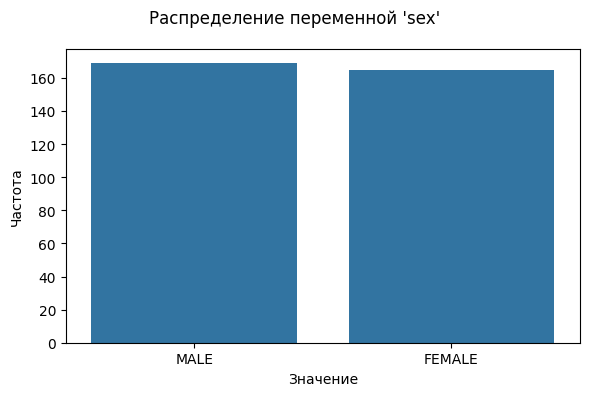

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(df["sex"].value_counts(), ax=ax)
ax.set_xlabel("Значение")
ax.set_ylabel("Частота")

plt.suptitle(f"Распределение переменной 'sex'")
plt.tight_layout()
plt.show()

Значения распределены примерно поровну.

### Распределение числовых переменных

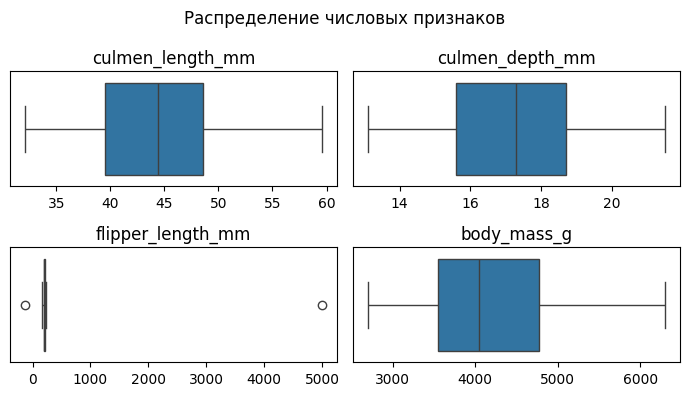

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(7, 4))

for i, col in enumerate(numeric_columns):
    row_idx, col_idx = divmod(i, 2)
    sns.boxplot(df[col], ax=ax[row_idx, col_idx], orient="h")
    ax[row_idx, col_idx].set_title(col)
    ax[row_idx, col_idx].set_xlabel(None)
    ax[row_idx, col_idx].set_yticks([])

for i in range(len(numeric_columns), len(ax.flatten())):
    fig.delaxes(ax.flatten()[i])

plt.suptitle("Распределение числовых признаков")
plt.tight_layout()
plt.show()

Можно видеть, что столбец flipper_length_mm имеет два выброса.

In [16]:
print(df[df["flipper_length_mm"] > 4000])
print(df[df["flipper_length_mm"] < 0])

   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g   sex
9              42.0             20.2             5000.0       4250.0  MALE
    culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g   sex
14              34.6             21.1             -132.0       4400.0  MALE


Удалим их из набора данных.

In [17]:
df = df.drop([9, 14])

Проверим параметры данных после преобразований.

In [18]:
# Результаты EDA для числовых признаков
numeric_columns_stats(df[numeric_columns])

,Доля пропусков,Минимум,Максимум,Среднее,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
culmen_length_mm,0.0,32.1,59.6,44.02,44.7,29.73,36.61,50.8,39.5,48.62
culmen_depth_mm,0.0,13.1,21.5,17.15,17.3,3.84,14.31,19.5,15.6,18.70
flipper_length_mm,0.0,172.0,231.0,200.98,197.0,197.01,185.00,221.0,190.0,213.00
body_mass_g,0.0,2700.0,6300.0,4206.48,4025.0,650218.51,3300.00,5445.0,3550.0,4781.25


In [19]:
# Результаты EDA для категориальных признаков
categoric_columns_stats(df[categoric_columns])

,Доля пропусков,Количество уникальных значений,Мода
sex,0.0,2,MALE


### Анализ корреляций

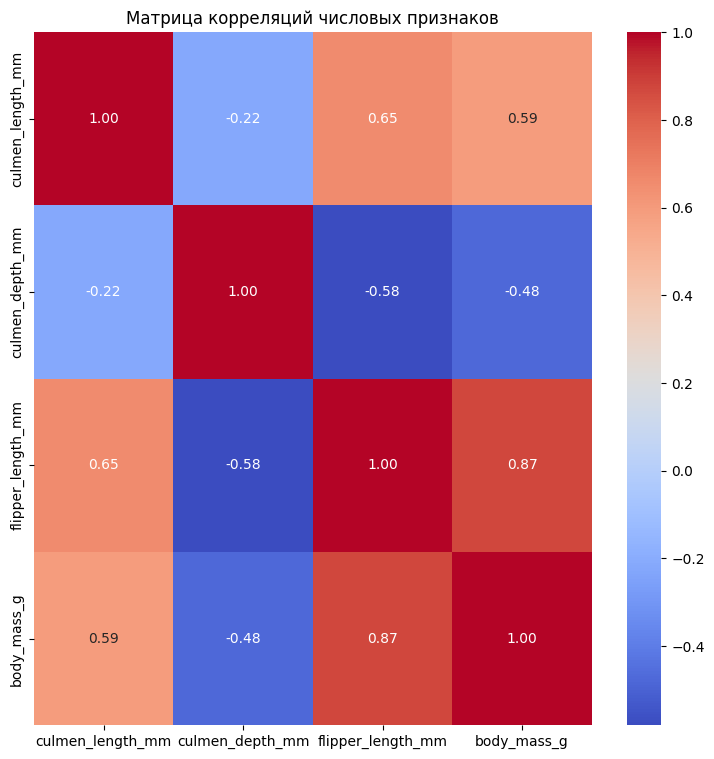

In [20]:
plt.figure(figsize=(9, 9))
correlation_matrix = df[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляций числовых признаков")
plt.show()

В данных присутствуют ожидаемые корреляции между flipper_length_mm - body_mass_g, flipper_length_mm - culmen_length_mm. Оставим данные без изменений.

### Масштабирование данных

In [21]:
df_scaled = df.copy()

le = LabelEncoder()
scaler = StandardScaler()

df_scaled["sex"] = le.fit_transform(df_scaled["sex"])
df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df.columns)

df_scaled.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,-0.903906,0.790360,-1.425342,-0.566948,0.993994
1,-0.830434,0.126187,-1.068577,-0.504847,-1.006042
2,-0.683490,0.432728,-0.426399,-1.187953,-1.006042
3,-1.344738,1.096901,-0.569105,-0.939551,-1.006042
4,-0.867170,1.761074,-0.783164,-0.691149,0.993994


## Кластеризация AgglomerativeClustering

### Подбор гиперпараметров

In [22]:
best_score = -float("inf")
best_params = None

n_clusters_options = [*range(2, 11)]
metric_options = ["euclidean", "l1", "l2", "manhattan", "cosine"]
linkage_options = ["ward", "complete", "average", "single"]

for n_clusters in n_clusters_options:
    for metric in metric_options:
        for link in linkage_options:
            if link == "ward" and metric != "euclidean":
                continue

            model = AgglomerativeClustering(
                n_clusters=n_clusters, metric=metric, linkage=link
            )
            labels = model.fit_predict(df_scaled)
            score = silhouette_score(df_scaled, labels)

            if score > best_score:
                best_score = score
                best_params = {
                    "n_clusters": n_clusters,
                    "metric": metric,
                    "linkage": link,
                }

print(f"silhouette_score={best_score}")
best_params

silhouette_score=0.5279608441884877


{'n_clusters': 6, 'metric': 'cosine', 'linkage': 'average'}

###  Визуализация кластеров

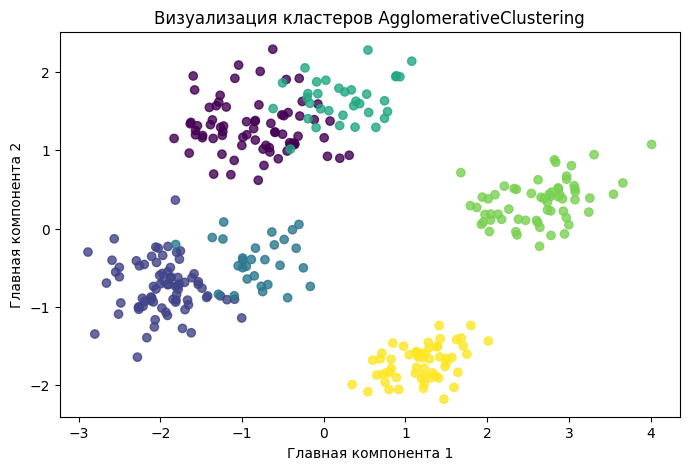

In [23]:
# Модель с оптимальными параметрами
agglomerative_fine_tune = AgglomerativeClustering(**best_params)
agglomerative_fine_tune.fit(df_scaled)

# Визуализация кластеров после снижения размерности
pca = PCA(n_components=2)
df_scaled_pca = pca.fit_transform(df_scaled.values)

plt.figure(figsize=(8, 5))
plt.scatter(
    df_scaled_pca[:, 0],
    df_scaled_pca[:, 1],
    c=agglomerative_fine_tune.labels_,
    alpha=0.8,
)
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.title("Визуализация кластеров AgglomerativeClustering")
plt.show()

На графике, после снижения размерности, можно видеть набор хорошо различимых кластеров. Их число равно 6 и соответсвует найденному ранее в методе KMeans.

###  Дендрограмма по кластерам

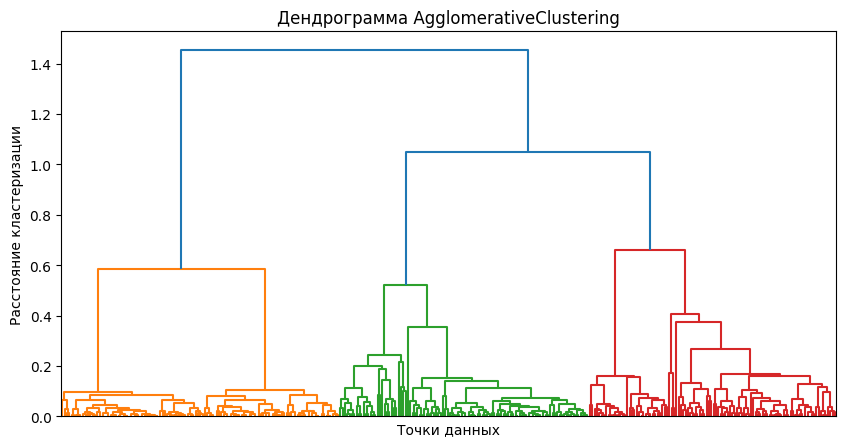

In [24]:
plt.figure(figsize=(10, 5))
linked = linkage(df_scaled, method=best_params["linkage"], metric=best_params["metric"])
dendrogram(linked)
plt.title("Дендрограмма AgglomerativeClustering")
plt.xlabel("Точки данных")
plt.xticks([])
plt.ylabel("Расстояние кластеризации")
plt.show()

Дендрограмма показывает иерархическую структуру кластеров, которые объединяются на разных уровнях. Видно, что данные хорошо разделены на 6 кластеров, подтверждая правильность выбора гиперпараметров.

###  Сохранение модели

In [25]:
joblib.dump(agglomerative_fine_tune, "agglomerative_model.joblib")
print("Модель сохранена!")

Модель сохранена!


### Кластеризация с целевым признаком

In [26]:
X_scaled = df_scaled.drop(columns=["sex"])
y = le.fit_transform(df["sex"])

In [27]:
best_score = -float("inf")
best_params = None

n_clusters_options = [2]
metric_options = ["euclidean", "l1", "l2", "manhattan", "cosine"]
linkage_options = ["ward", "complete", "average", "single"]

for n_clusters in n_clusters_options:
    for metric in metric_options:
        for link in linkage_options:
            if link == "ward" and metric != "euclidean":
                continue

            model = AgglomerativeClustering(
                n_clusters=n_clusters, metric=metric, linkage=link
            )
            labels = model.fit_predict(X_scaled)
            score = adjusted_rand_score(y, labels)

            if score > best_score:
                best_score = score
                best_params = {
                    "n_clusters": n_clusters,
                    "metric": metric,
                    "linkage": link,
                }

print(f"adjusted_rand_score={best_score}")
best_params

adjusted_rand_score=7.30219682437517e-05


{'n_clusters': 2, 'metric': 'euclidean', 'linkage': 'single'}

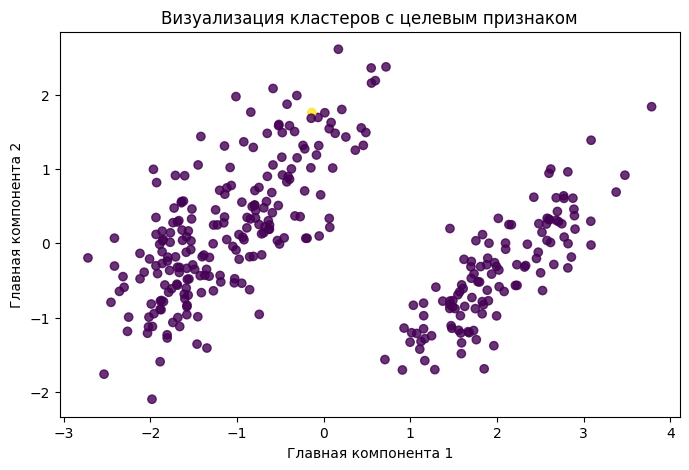

In [28]:
# Модель с оптимальными параметрами
agglomerative_fine_tune = AgglomerativeClustering(**best_params)
agglomerative_fine_tune.fit(X_scaled)

# Визуализация кластеров после снижения размерности
pca = PCA(n_components=2)
X_scaled_pca = pca.fit_transform(X_scaled.values)

plt.figure(figsize=(8, 5))
plt.scatter(
    X_scaled_pca[:, 0],
    X_scaled_pca[:, 1],
    c=agglomerative_fine_tune.labels_,
    alpha=0.8,
)
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.title("Визуализация кластеров с целевым признаком")
plt.show()

При разделении данных на 2 кластера достигается очень низкое качество кластеризации данных с величиной adjusted_rand_score близкой к нулю.

## Кластеризация DBSCAN

Подбор гиперпараметров.

In [29]:
best_score = -float("inf")
best_params = None

eps_options = [*np.arange(0.1, 1.5, 0.1)]
min_samples_options = [*range(2, 11)]

for eps in eps_options:
    for min_samples in min_samples_options:
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(df_scaled)

        # Проверка, что модель нашла хотя бы 2 кластера (иначе silhouette_score не применим)
        if len(set(labels)) > 1:
            score = silhouette_score(df_scaled, labels)
            if score > best_score:
                best_score = score
                best_params = {"eps": eps, "min_samples": min_samples}

print(f"silhouette_score={best_score}")
best_params

silhouette_score=0.5060089996631703


{'eps': np.float64(0.8), 'min_samples': 7}

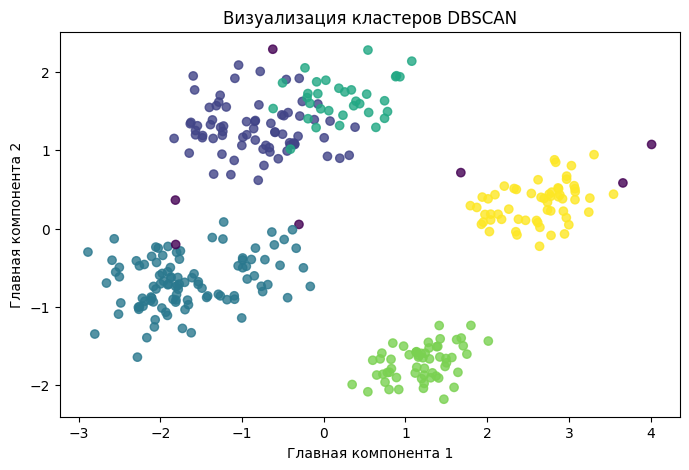

In [30]:
# Модель с оптимальными параметрами
dbscan_fine_tune = DBSCAN(**best_params)
dbscan_fine_tune.fit(df_scaled)

# Визуализация кластеров после снижения размерности
pca = PCA(n_components=2)
df_scaled_pca = pca.fit_transform(df_scaled.values)

plt.figure(figsize=(8, 5))
plt.scatter(
    df_scaled_pca[:, 0],
    df_scaled_pca[:, 1],
    c=dbscan_fine_tune.labels_,
    alpha=0.8,
)
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.title("Визуализация кластеров DBSCAN")
plt.show()

Точность кластеризации алгоритма DBSCAN немного ниже, чем AgglomerativeClustering (судя по величине коэффициента силуэта). С его помощью удается выделить 5 кластеров и шум.